# Model validation stations

Note: this notebook requires the model output data

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Important Disclaimer</strong><br><br>
  This model setup is a <strong>simplified version</strong> of a detailed model developed by DHI. It does <strong>not</strong> resolve fine-scale processes and is <strong>not calibrated</strong> for operational use. Use is limited to <strong>educational and research purposes only</strong> — results should <strong>not</strong> inform decision-making. Performance shown here does <strong>not</strong> represent that of DHI’s high-resolution models.
</div>

### Import packages

In [1]:
import modelskill as ms
import matplotlib.pyplot as plt
import helper as h
import plotting as pl
import pandas as pd
from pathlib import Path
import mikeio

### Define paths

In [14]:
obs_fldr = "../observations/" 
meas_fldr = "../observations/measurements/" 
mr_fldr = "../output/"    
#mr_fldr = "../output_sample/"     # use this if you have not downloaded the full data from Zenodo yet
mr_fn = f"{mr_fldr}Area.dfsu"

In [29]:
fig_fldr = "../figures/" 
save_fig = False if "sample" in mr_fldr else True
show_fig = True

### Load data

In [15]:
# Load observation data
tplist = h.get_tp_point_obs(obs_fldr=obs_fldr, meas_fldr=meas_fldr, station_file="stations_subset.csv")
mwdlist = h.get_mwd_point_obs(obs_fldr=obs_fldr, meas_fldr=meas_fldr, station_file="stations.csv")

In [16]:
# Load MIKE21 simulation data
mr_tp = ms.DfsuModelResult(mr_fn, name="MIKE21", item=1)
mr_dir = ms.DfsuModelResult(mr_fn, name="MIKE21", item=3)

### Create modelskill comparer collection

We consider peak wave period (tp) and mean wave direction (mwd).

In [18]:
# tp
cmps = []
for o in tplist:
    try:
        cmps.append(ms.match(obs=o, mod=mr_tp))
    except Exception as e:
        print(f"Skipping {o.name} due to error: {e}")
        
cc_tp = ms.ComparerCollection(cmps)

Considering only observations with significant wave height larger than a certain threshold (e.g. 1.0 m) may be relevant, since lower wave heights may result in inaccurate measurements of the peak wave period.
## I am not sure I understand the code exactly, that is fine as long as it works, but modelskill has something called `aux` variables, so when you create the comparer, you add `item=Tp` and `aux_item=Hm0` and then you can directly filter by Hm0>1.0m, just saying. But if it works now, you can keep it, up to you.

In [19]:
# Sort out small wave heights for better comparison
cmps = []
threshold = 1.0  # m

for i, cmp in enumerate(cc_tp):
    cmps.append(cmp.where(cmp.data['VHM0'] > threshold))

cc_tp_aux = ms.ComparerCollection(cmps)

In [20]:
# mwd
cmps = []
for o in mwdlist:
    try:
        cmps.append(ms.match(obs=o, mod=mr_dir))
    except Exception as e:
        print(f"Skipping {o.name} due to error: {e}")
        
cc_mwd = ms.ComparerCollection(cmps)

## Skill tables

In [22]:
# Print statistics for the tp-component
cc_tp_aux.skill().round(3)

,n,bias,rmse,urmse,mae,cc,si,r2
observation,,,,,,,,
6201045,12236,0.207,1.619,1.606,0.955,0.798,0.183,0.563
6201047,12607,0.511,1.880,1.810,1.038,0.756,0.215,0.404
6201050,7484,0.551,1.902,1.821,1.131,0.771,0.245,0.492
6201059,8428,0.424,1.304,1.233,0.838,0.678,0.190,0.153
A121,9274,1.123,2.927,2.703,1.496,0.549,0.324,-0.494
Europlatform2,54995,0.502,1.347,1.250,0.774,0.624,0.197,-0.180
F3platform,74961,0.431,1.709,1.654,0.898,0.720,0.214,0.283
IJmuidenMunitiestort,50076,0.555,1.764,1.675,0.968,0.645,0.244,0.063
J61,68416,0.347,1.544,1.505,0.842,0.727,0.206,0.376


In [23]:
# Print statistics for the mwd-component (use circular metrics)
cc_mwd.skill(metrics=["c_bias", "c_rmse", "c_urmse", "c_mae", "cc", "si", "r2"]).round(3)

,n,c_bias,c_rmse,c_urmse,c_mae,cc,si,r2
observation,,,,,,,,
Europlatform3,8686,2.119,17.276,17.140,9.083,0.675,0.321,0.309
IJmuidenMunitiestort,101242,5.375,24.858,24.249,13.531,0.749,0.331,0.463
WaddenEierlandseGat,97368,4.499,24.579,24.132,13.392,0.785,0.325,0.567


## Scatter plots

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Important Disclaimer</strong><br><br>
  This model setup is a <strong>simplified version</strong> of a detailed model developed by DHI. It does <strong>not</strong> resolve fine-scale processes and is <strong>not calibrated</strong> for operational use. Use is limited to <strong>educational and research purposes only</strong> — results should <strong>not</strong> inform decision-making. Performance shown here does <strong>not</strong> represent that of DHI’s high-resolution models.
</div>

### Peak wave period

In [31]:
cc_tp_aux[0]

<Comparer>
Quantity: Wave period [s]
Observation: 6201045, n_points=12236
Model(s):
0: MIKE21
 Auxiliary: VHM0

In [30]:
n_points_shown = 10000
for cmp in cc_tp_aux:
    cmp.plot_scatter(skill_table=True, show_points=n_points_shown, figsize=(6,5), bins=40);
    if save_fig:
        plt.savefig(f"{fig_fldr}peak_wave_period_comparison_{cmp.name}.png", bbox_inches='tight');
        print(f"fig saved to: {fig_fldr}peak_wave_period_comparison_{cmp.name}.png")
    if show_fig:
        plt.show()
    else:
        plt.close()

AttributeError: 'Comparer' object has no attribute 'plot_scatter'

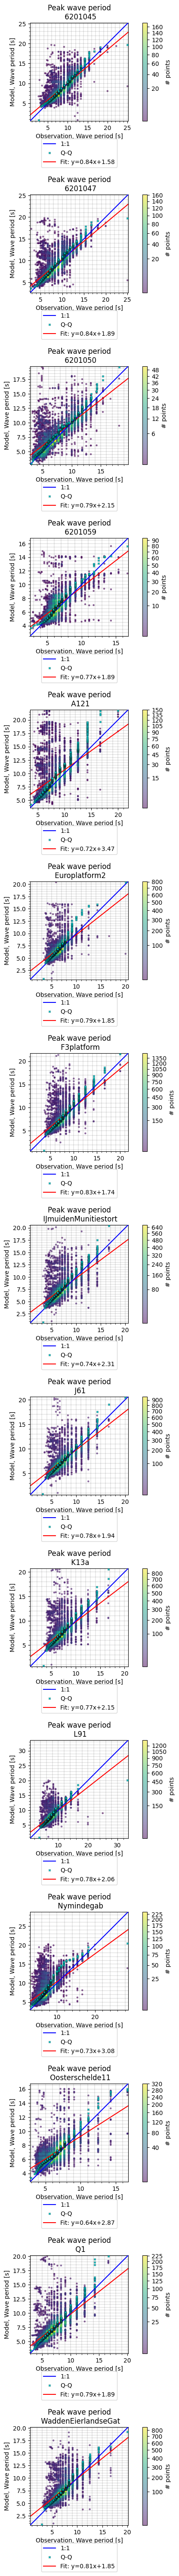

In [24]:
pl.plot_scatter_cc(cc = cc_tp_aux, title='Peak wave period') #I liked the Hm0 plots better, as in, larger and with the skill table on the right side. These plots are very tiny for some reason, but up to you. Same for MWD

### Mean wave direction

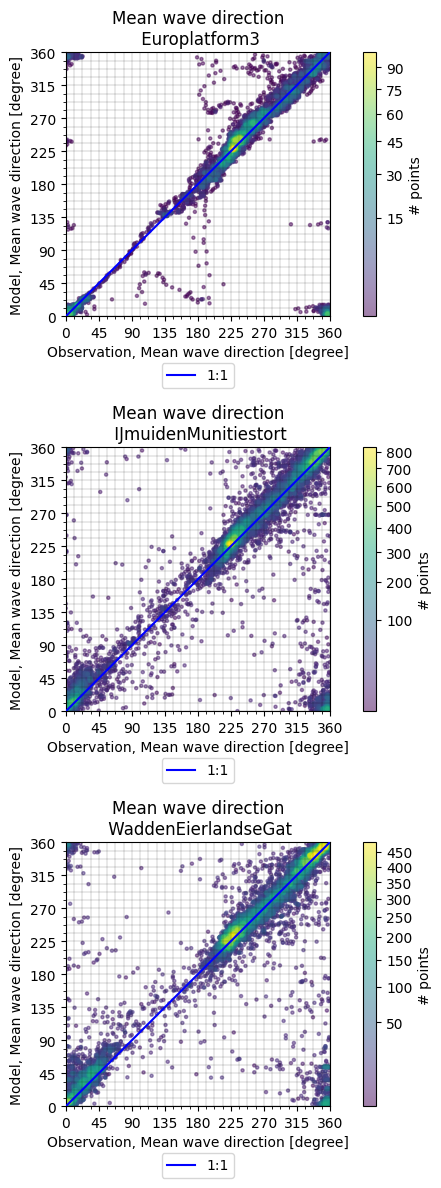

In [25]:
# Scatter plot
pl.plot_scatter_cc(cc = cc_mwd, title='Mean wave direction')

## Timeseries

### Peak wave period

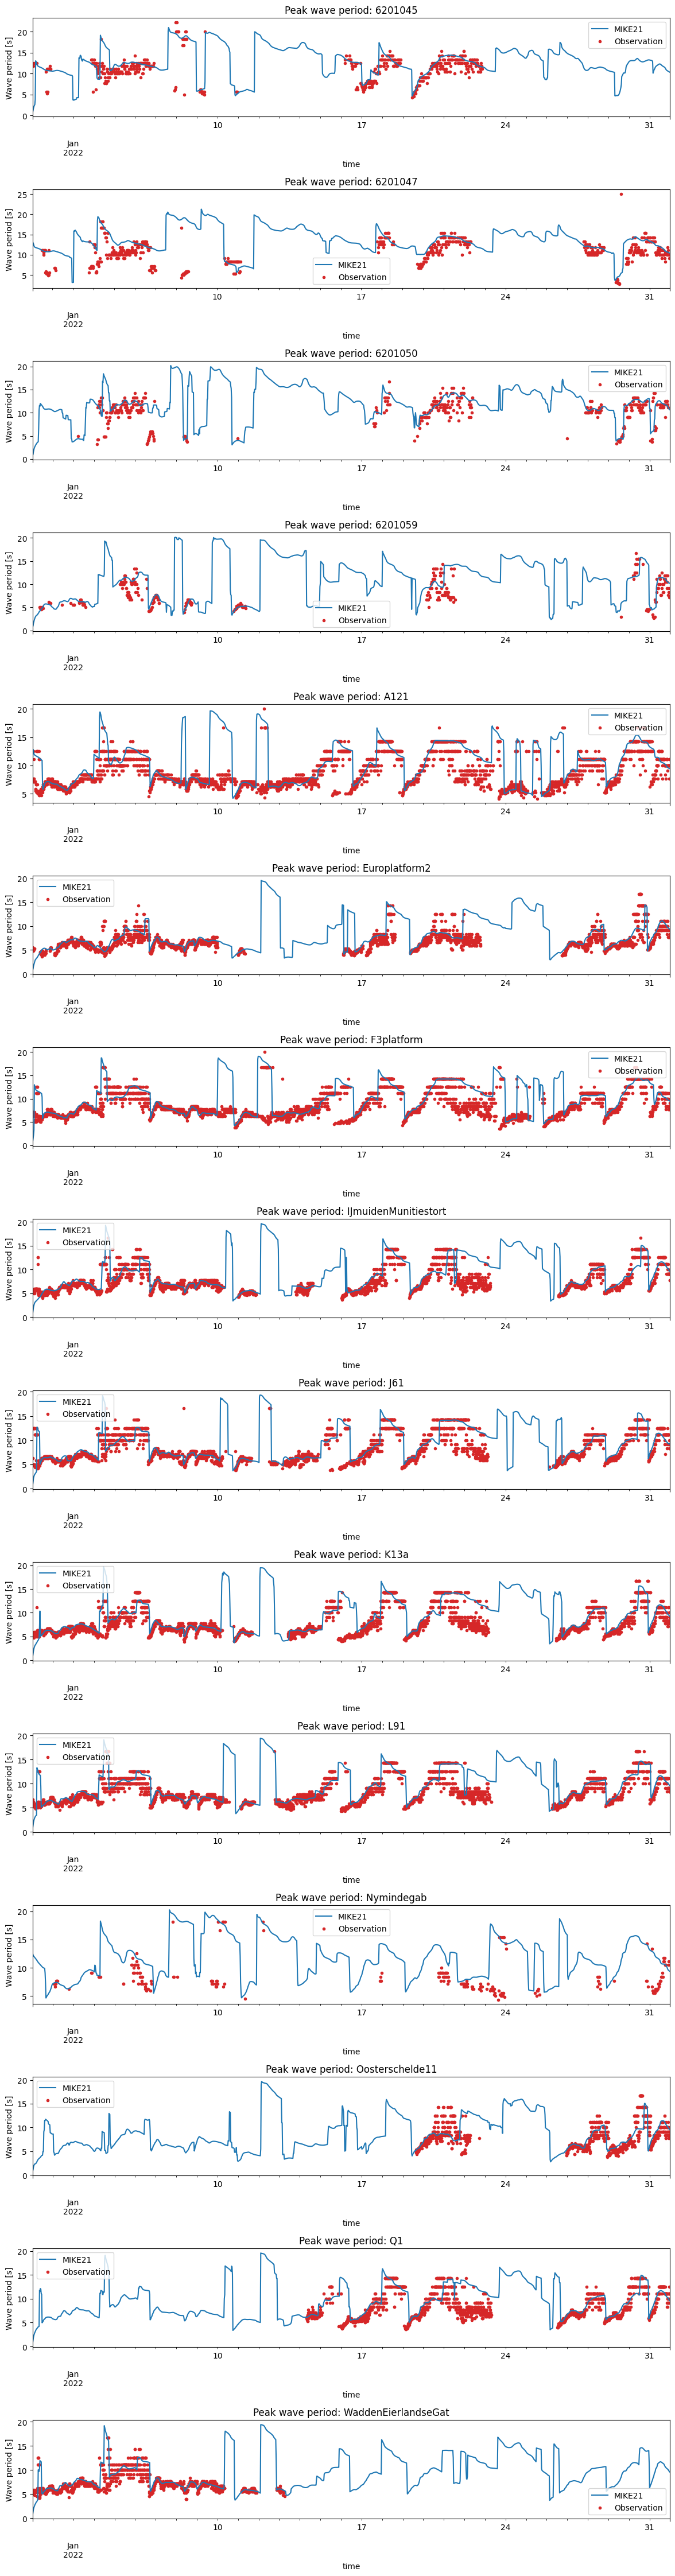

In [26]:
pl.plot_timeseries_currents(cc = cc_tp_aux, title='Peak wave period')

## KDE plot

### Mean wave direction

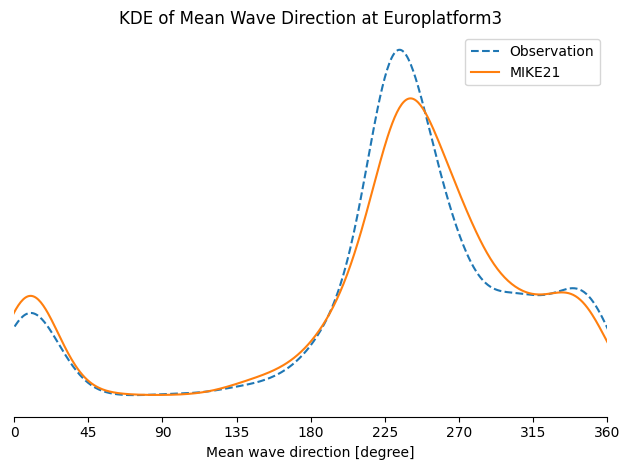

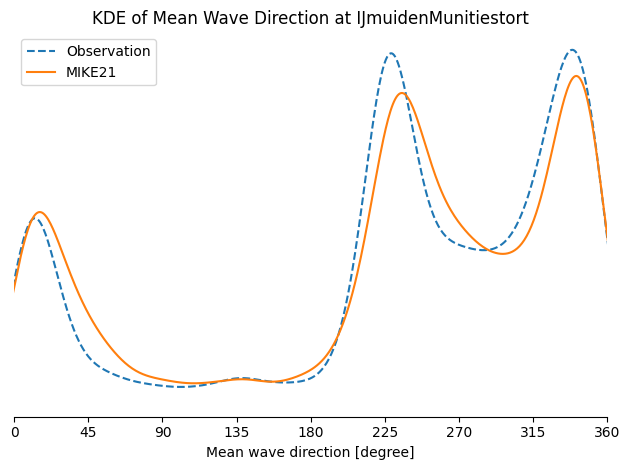

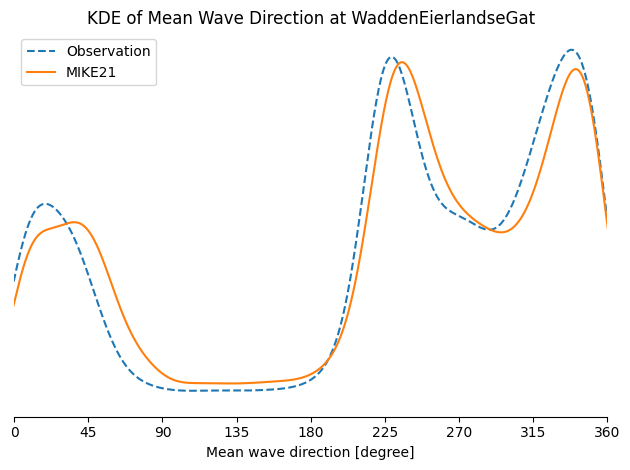

In [27]:
for cc in cc_mwd:
    ax = cc.plot.kde(xlim=(0, 360))
    ax.set_title(f"KDE of Mean Wave Direction at {cc.name}")
    plt.tight_layout()
plt.show()